In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from pytorch_sklearn.neural_network.neural_network import NeuralNetwork
from pytorch_sklearn.neural_network.generative_network import CycleGAN
from pytorch_sklearn.callbacks.predefined import Verbose, History, EarlyStopping
from pytorch_sklearn.utils.progress_bar import print_progress

from sonn.building_blocks import Downsample2d, Upsample2d
from sonn.norm_layers import LayerNormNLP2d
from sonn.superonn_final import SuperONN2d

from PIL import Image

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.conv3(x)
    
class KillerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.ds1   = Downsample2d(32)  # 32 -> 64
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.ds2   = Downsample2d(64)  # 64 -> 128
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.up2   = Upsample2d(128)   # 128 -> 64
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.up1   = Upsample2d(64)    # 64 -> 32
        self.conv5 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.ds1(x)
        x = F.relu(self.conv2(x))
        x = self.ds2(x)
        x = F.relu(self.conv3(x))
        x = self.up2(x)
        x = F.relu(self.conv4(x))
        x = self.up1(x)
        return self.conv5(x)
    
class KillerONN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SuperONN2d(3, 32, q=3, kernel_size=3, padding=1)
        self.ds1   = Downsample2d(32)  # 32 -> 64
        self.ln1   = LayerNormNLP2d(64)
        self.conv2 = SuperONN2d(64, 64, q=3,  kernel_size=3, padding=1)
        self.ds2   = Downsample2d(64)  # 64 -> 128
        self.ln2   = LayerNormNLP2d(128)
        self.conv3 = SuperONN2d(128, 128, q=3, kernel_size=3, padding=1)
        self.up2   = Upsample2d(128)   # 128 -> 64
        self.ln3   = LayerNormNLP2d(64)
        self.conv4 = SuperONN2d(64, 64, q=3,  kernel_size=3, padding=1)
        self.up1   = Upsample2d(64)    # 64 -> 32
        self.ln4   = LayerNormNLP2d(32)
        self.conv5 = SuperONN2d(32, 3, q=3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.ds1(x)
        x = self.ln1(x)
        x = F.relu(self.conv2(x))
        x = self.ds2(x)
        x = self.ln2(x)
        x = F.relu(self.conv3(x))
        x = self.up2(x)
        x = self.ln3(x)
        x = F.relu(self.conv4(x))
        x = self.up1(x)
        x = self.ln4(x)
        return self.conv5(x)
    
class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=4)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=4)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = F.relu(self.maxpool1(self.conv1(x)))
        x = F.relu(self.maxpool2(self.conv2(x)))
        x = self.maxpool3(self.conv3(x))
        return x.view(-1, 1)

In [3]:
model = SimpleDiscriminator()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
crit = nn.MSELoss()

In [4]:
X = torch.randn(10, 3, 32, 32)
y = torch.randn(10, 1)

In [5]:
net = NeuralNetwork(model, optim, crit)

In [6]:
net.callbacks

In [7]:
net.fit(
    train_X=X,
    train_y=y,
    max_epochs=50,
    callbacks=[Verbose(notebook=True)],
    metrics={'l1loss': nn.L1Loss(), 'l2loss': nn.MSELoss()},
)

Epoch 1/50
1/1 [====================] - train_loss: 0.416 - train_l1loss: 0.462 - train_l2loss: 0.416 - Time: 0.49 - ETA: 0.00
Epoch 2/50
1/1 [====================] - train_loss: 0.394 - train_l1loss: 0.443 - train_l2loss: 0.394 - Time: 0.01 - ETA: 0.00
Epoch 3/50
1/1 [====================] - train_loss: 0.397 - train_l1loss: 0.435 - train_l2loss: 0.397 - Time: 0.00 - ETA: 0.00
Epoch 4/50
1/1 [====================] - train_loss: 0.373 - train_l1loss: 0.410 - train_l2loss: 0.373 - Time: 0.00 - ETA: 0.00
Epoch 5/50
1/1 [====================] - train_loss: 0.340 - train_l1loss: 0.393 - train_l2loss: 0.340 - Time: 0.00 - ETA: 0.00
Epoch 6/50
1/1 [====================] - train_loss: 0.334 - train_l1loss: 0.384 - train_l2loss: 0.334 - Time: 0.01 - ETA: 0.00
Epoch 7/50
1/1 [====================] - train_loss: 0.323 - train_l1loss: 0.385 - train_l2loss: 0.323 - Time: 0.01 - ETA: 0.00
Epoch 8/50
1/1 [====================] - train_loss: 0.308 - train_l1loss: 0.377 - train_l2loss: 0.308 - Time: 0

In [8]:
net.predict(X)
gen = net.predict_generator(X)
for i in gen:
    print(i)
score = net.score(X, y)
print(score)

tensor([[ 0.6183],
        [-1.2553],
        [ 0.1615],
        [ 0.2675],
        [-0.0538],
        [ 0.0288],
        [ 1.2615],
        [ 0.3733],
        [ 0.8357],
        [ 0.2357]], device='cuda:0')
tensor(0.0008)


In [9]:
class CycleGANDataset(Dataset):
    def __init__(self):
        self.A = torch.randn(10, 3, 32, 32) * .1
        self.B = torch.randn(10, 3, 32, 32) * .8

    def __len__(self):
        return 10
    
    def __getitem__(self, index):
        return self.A[index], self.B[index]

In [10]:
class ZenDataset(Dataset):
    def __init__(self):
        self.Zen = tvt.ToTensor()(Image.open('zen2.jpg')).unsqueeze(0)
        self.Bro = tvt.ToTensor()(Image.open('bro.jpg')).unsqueeze(0)

    def __len__(self):
        return 1
    
    def __getitem__(self, index):
        return self.Zen[index], self.Bro[index]

In [11]:
class STDMetric:
    def __init__(self):
        self.stdA = []
        self.stdB = []
        self.stdA2B = []
        self.stdB2A = []

    def __call__(self, batch_out, batch_y):
        A2B, B2A = batch_out
        A, B = batch_y
        self.stdA.append(A.std().item())
        self.stdB.append(B.std().item())
        self.stdA2B.append(A2B.std().item())
        self.stdB2A.append(B2A.std().item())
        return 0

In [12]:
G_A = SimpleCNN()
G_B = SimpleCNN()
# G_A = KillerCNN()
# G_B = KillerCNN()
# G_A = KillerONN()
# G_B = KillerONN()
D_A = SimpleDiscriminator()
D_B = SimpleDiscriminator()

G_optim = torch.optim.Adam(list(G_A.parameters()) + list(G_B.parameters()), lr=0.001)
D_optim = torch.optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=0.001)

In [13]:
cycle_gan = CycleGAN(G_A, G_B, D_A, D_B, G_optim, D_optim)

In [14]:
cycle_gan_ds = CycleGANDataset()
zen_ds = ZenDataset()

In [15]:
std_metric = STDMetric()

In [18]:
cycle_gan.fit(
    train_X=cycle_gan_ds,
    max_epochs=200,
    callbacks=[Verbose(notebook=True)],
    metrics={'std': std_metric},
)

Epoch 501/700
1/1 [====================] - train_loss: 1.614 - train_std: 2.868 - Time: 0.10 - ETA: 0.00
Epoch 502/700
1/1 [====================] - train_loss: 1.623 - train_std: 2.831 - Time: 0.03 - ETA: 0.00
Epoch 503/700
1/1 [====================] - train_loss: 1.592 - train_std: 2.803 - Time: 0.03 - ETA: 0.00
Epoch 504/700
1/1 [====================] - train_loss: 1.601 - train_std: 2.785 - Time: 0.03 - ETA: 0.00
Epoch 505/700
1/1 [====================] - train_loss: 1.596 - train_std: 2.789 - Time: 0.03 - ETA: 0.00
Epoch 506/700
1/1 [====================] - train_loss: 1.556 - train_std: 2.810 - Time: 0.03 - ETA: 0.00
Epoch 507/700
1/1 [====================] - train_loss: 1.550 - train_std: 2.835 - Time: 0.03 - ETA: 0.00
Epoch 508/700
1/1 [====================] - train_loss: 1.539 - train_std: 2.863 - Time: 0.03 - ETA: 0.00
Epoch 509/700
1/1 [====================] - train_loss: 1.500 - train_std: 2.891 - Time: 0.02 - ETA: 0.00
Epoch 510/700
1/1 [====================] - train_loss: 

In [20]:
cycle_gan.G_elo, cycle_gan.D_elo

(0, 0)

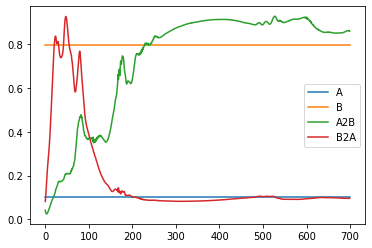

In [19]:
plt.plot(std_metric.stdA, label='A')
plt.plot(std_metric.stdB, label='B')
plt.plot(std_metric.stdA2B, label='A2B')
plt.plot(std_metric.stdB2A, label='B2A')
plt.legend()
plt.show()

In [21]:
preds = cycle_gan.predict(cycle_gan_ds)

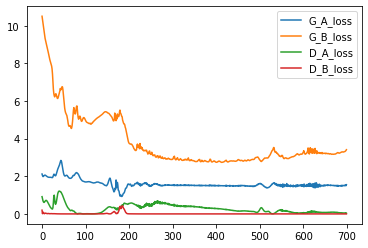

In [22]:
plt.plot(cycle_gan.history.track['train_G_A_loss'], label='G_A_loss')
plt.plot(cycle_gan.history.track['train_G_B_loss'], label='G_B_loss')
plt.plot(cycle_gan.history.track['train_D_A_loss'], label='D_A_loss')
plt.plot(cycle_gan.history.track['train_D_B_loss'], label='D_B_loss')
# plt.ylim(0, 4)
plt.legend()
plt.show()

In [23]:
preds = cycle_gan.predict(cycle_gan_ds)
score = cycle_gan.score(cycle_gan_ds)
print(score)
out_gen = cycle_gan.predict_generator(cycle_gan_ds)
for i in out_gen:
    print(i.__len__())

tensor([4.9519, 0.0731])
4


In [20]:
NeuralNetwork.save_class(cycle_gan, 'cycle_gan.pkl')

In [21]:
NeuralNetwork.load_class(cycle_gan, [], 'cycle_gan.pkl')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


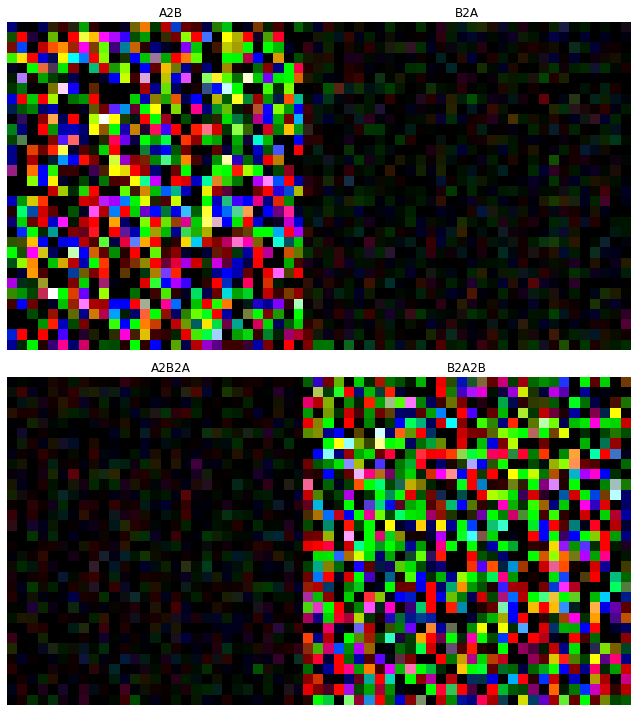

In [24]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(preds[0][0].permute(1, 2, 0).cpu(), vmin=preds[0][0].min(), vmax=preds[0][0].max())
plt.title('A2B')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(preds[1][0].permute(1, 2, 0).cpu(), vmin=preds[1][0].min(), vmax=preds[1][0].max())
plt.title('B2A')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(preds[2][0].permute(1, 2, 0).cpu(), vmin=preds[2][0].min(), vmax=preds[2][0].max())
plt.title('A2B2A')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(preds[3][0].permute(1, 2, 0).cpu(), vmin=preds[3][0].min(), vmax=preds[3][0].max())
plt.title('B2A2B')
plt.axis('off')
plt.gcf().tight_layout(w_pad=-10)
plt.show()

In [24]:
[pred.std() for pred in preds]

[tensor(0.1812, device='cuda:0'),
 tensor(0.6882, device='cuda:0'),
 tensor(0.0750, device='cuda:0'),
 tensor(0.5739, device='cuda:0')]